In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Data

I dati dal file "data8.csv" sono stati caricati, convertendo la colonna 'co2' in tipo numerico (gestendo il separatore decimale ',' ) e le colonne 'door' e 'window' in tipo categorico.

In [2]:
data= pd.read_csv("data8.csv", sep=';')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    1000 non-null   object
 1   co2     1000 non-null   object
 2   people  1000 non-null   int64 
 3   door    1000 non-null   int64 
 4   window  1000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 39.2+ KB


In [4]:
# Ensure the data is in a state similar to the initial load if necessary
# Assuming 'data' is already loaded and 'time' is already the index

# Convert 'co2' to numeric float, handling commas
data['co2'] = data['co2'].astype(str).str.replace(',', '.')
data['co2'] = pd.to_numeric(data['co2'])


# Convert 'door' and 'window' to categorical (binary)
data['door'] = data['door'].astype('category')
data['window'] = data['window'].astype('category')

# Display the data types and head to confirm
display(data.dtypes)
display(data.head())

,0
time,object
co2,float64
people,int64
door,category
window,category


,time,co2,people,door,window
0,2024-01-01 00:00:00,395.540718,0,0,0
1,2024-01-01 01:00:00,398.289772,0,0,0
2,2024-01-01 02:00:00,413.141453,1,0,0
3,2024-01-01 03:00:00,396.504279,0,0,0
4,2024-01-01 04:00:00,398.136520,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   time    1000 non-null   object  
 1   co2     1000 non-null   float64 
 2   people  1000 non-null   int64   
 3   door    1000 non-null   category
 4   window  1000 non-null   category
dtypes: category(2), float64(1), int64(1), object(1)
memory usage: 25.8+ KB


Sono stati generati grafici per visualizzare l'andamento di 'co2', 'people', 'door' e 'window' nel tempo, oltre a box plot per esaminare la distribuzione di 'co2' in relazione allo stato di porte e finestre e al numero di persone.

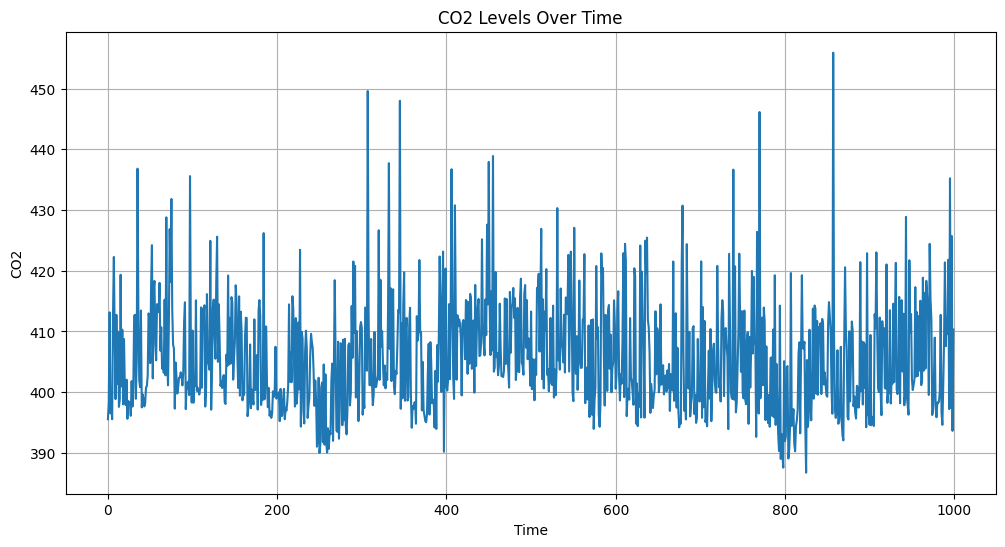

In [6]:

# Plot CO2 over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['co2'])
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Levels Over Time')
plt.grid(True)
plt.show()

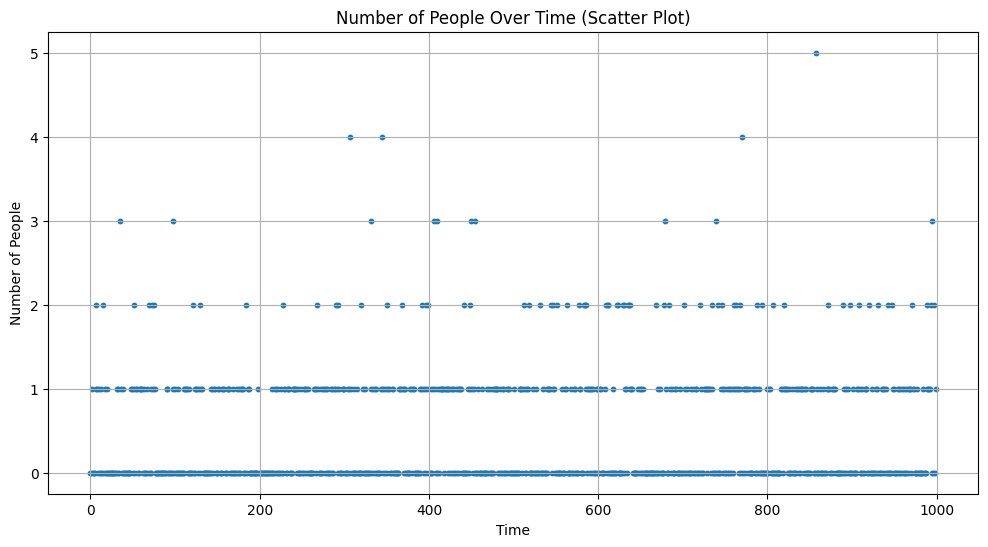

In [7]:


# Plot People over time using a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(data.index, data['people'], s=10) # Using scatter plot with small marker size
plt.xlabel('Time')
plt.ylabel('Number of People')
plt.title('Number of People Over Time (Scatter Plot)')
plt.grid(True)
plt.show()

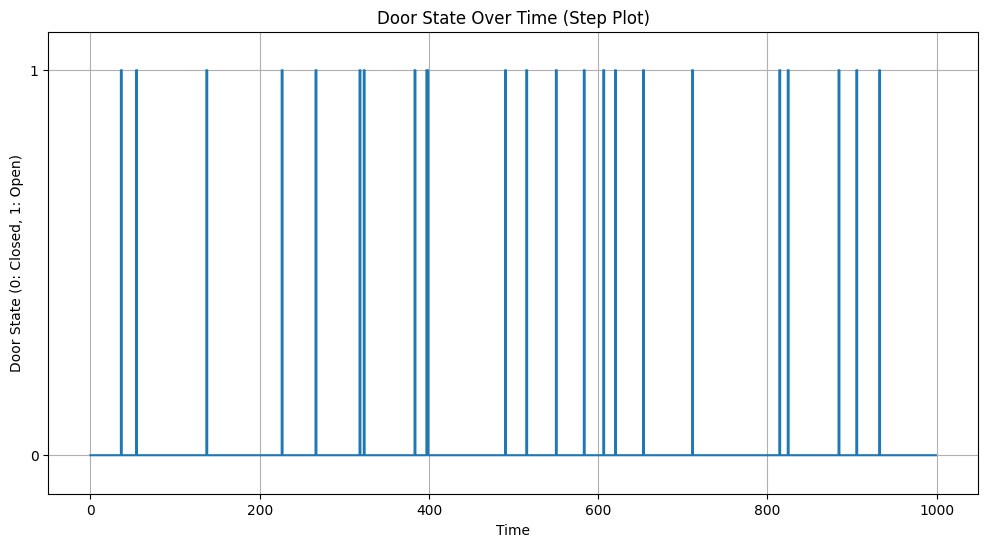

In [8]:


# Plot Door state over time using a step plot
plt.figure(figsize=(12, 6))
plt.step(data.index, data['door'])
plt.xlabel('Time')
plt.ylabel('Door State (0: Closed, 1: Open)')
plt.title('Door State Over Time (Step Plot)')
plt.yticks([0, 1]) # Set y-ticks to only 0 and 1
plt.ylim([-0.1, 1.1]) # Set y-axis limits for better visualization
plt.grid(True)
plt.show()

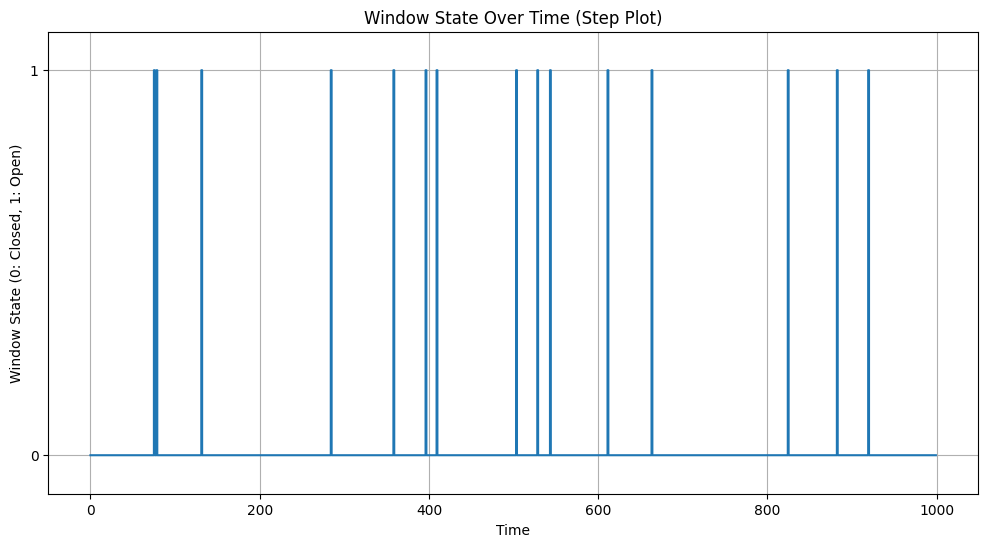

In [9]:


# Plot Window state over time using a step plot
plt.figure(figsize=(12, 6))
plt.step(data.index, data['window'])
plt.xlabel('Time')
plt.ylabel('Window State (0: Closed, 1: Open)')
plt.title('Window State Over Time (Step Plot)')
plt.yticks([0, 1]) # Set y-ticks to only 0 and 1
plt.ylim([-0.1, 1.1]) # Set y-axis limits for better visualization
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

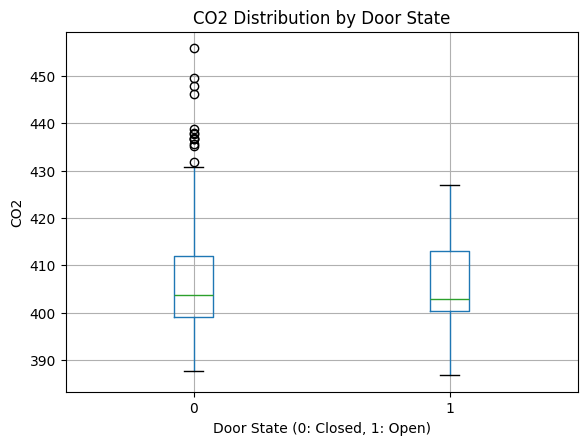

<Figure size 800x600 with 0 Axes>

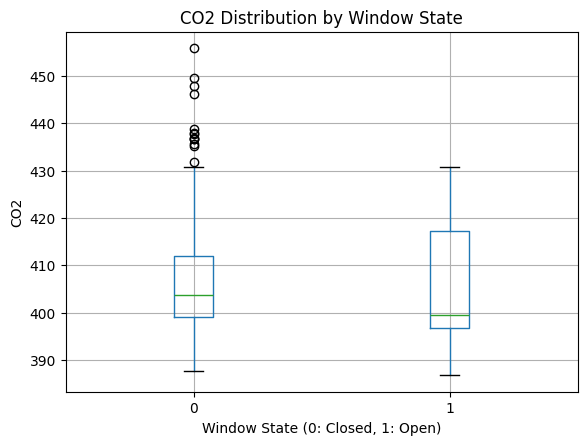

In [10]:


# Box plot: CO2 vs Door
plt.figure(figsize=(8, 6))
data.boxplot(column='co2', by='door')
plt.xlabel('Door State (0: Closed, 1: Open)')
plt.ylabel('CO2')
plt.title('CO2 Distribution by Door State')
plt.suptitle('') # Suppress the default suptitle
plt.grid(True)
plt.show()

# Box plot: CO2 vs Window
plt.figure(figsize=(8, 6))
data.boxplot(column='co2', by='window')
plt.xlabel('Window State (0: Closed, 1: Open)')
plt.ylabel('CO2')
plt.title('CO2 Distribution by Window State')
plt.suptitle('') # Suppress the default suptitle
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

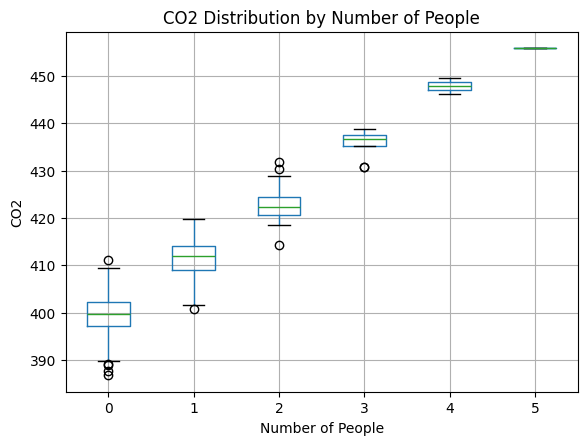

In [11]:


# Box plot: CO2 vs People
plt.figure(figsize=(8, 6))
data.boxplot(column='co2', by='people')
plt.xlabel('Number of People')
plt.ylabel('CO2')
plt.title('CO2 Distribution by Number of People')
plt.suptitle('') # Suppress the default suptitle
plt.grid(True)
plt.show()

# OLS model

Sono stati stimati diversi modelli di regressione OLS per esplorare la relazione tra 'co2' e le variabili predittrici ('people', 'door', 'window' e le loro interazioni). Il modello con 'people', 'window' e l'interazione tra 'door' e 'window' ('door:window') è stato scelto come modello semplificato ( model_simplified ).

In [12]:
# import statsmodels.formula.api as smf

model_1 = smf.ols('co2 ~ people', data=data).fit()
print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     4907.
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:                -2743.9
No. Observations:                1000   AIC:                             5492.
Df Residuals:                     998   BIC:                             5502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    399.6233      0.148   2699.519      0.0

In [13]:
# import statsmodels.formula.api as smf

model_2 = smf.ols('co2 ~ people + window', data=data).fit()
print(model_2.summary())


                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     2486.
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:                -2738.1
No. Observations:                1000   AIC:                             5482.
Df Residuals:                     997   BIC:                             5497.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     399.6589      0.148   2707.335      

In [14]:
# import statsmodels.formula.api as smf

model_3 = smf.ols('co2 ~ people + window + door', data=data).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1656.
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:                -2737.8
No. Observations:                1000   AIC:                             5484.
Df Residuals:                     996   BIC:                             5503.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     399.6690      0.148   2692.016      

In [15]:
# import statsmodels.formula.api as smf

model_4 = smf.ols('co2 ~ people + window + door + door:window', data=data).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1251.
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:                -2734.5
No. Observations:                1000   AIC:                             5479.
Df Residuals:                     995   BIC:                             5504.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               399.66

In [16]:
# import statsmodels.formula.api as smf

model_5 = smf.ols('co2 ~ people + window + door + door:window + people : door', data=data).fit()
print(model_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:                -2734.1
No. Observations:                1000   AIC:                             5480.
Df Residuals:                     994   BIC:                             5510.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               399.65

In [17]:
# import statsmodels.formula.api as smf

model_6 = smf.ols('co2 ~ people + window + door:window + people : door + window:people', data=data).fit()
print(model_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     833.2
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:                -2734.0
No. Observations:                1000   AIC:                             5482.
Df Residuals:                     993   BIC:                             5516.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             399.6643    

In [18]:
# import statsmodels.formula.api as smf

model_simplified = smf.ols('co2 ~ people + window + door:window', data=data).fit()
print(model_simplified.summary())


                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1251.
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:                -2734.5
No. Observations:                1000   AIC:                             5479.
Df Residuals:                     995   BIC:                             5504.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             399.6692    

## Residuals

È stato creato un grafico Q-Q dei residui del modello OLS semplificato (
model_simplified ) per verificare visivamente la normalità.

È stato eseguito il test di Shapiro-Wilk sui residui per una verifica formale della normalità. Il test suggerisce che i residui sono normalmente distribuiti.

Sono stati generati grafici ACF e PACF dei residui per identificare eventuali autocorrelazioni residue non catturate dal modello OLS. I grafici mostrano una struttura di autocorrelazione nei residui.

<Figure size 800x600 with 0 Axes>

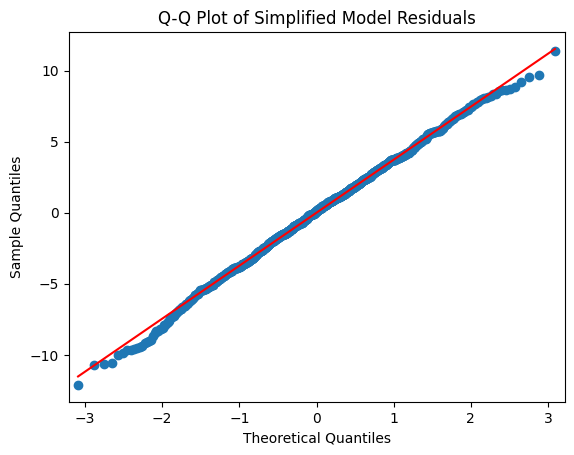

In [19]:

# Assuming 'model_simplified' from cell is the intended simplified model

# Calculate the residuals from the simplified model
residuals_simplified = model_simplified.resid


# Plot a Q-Q plot of the residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_simplified, line='s')
plt.title('Q-Q Plot of Simplified Model Residuals')
plt.show()

In [20]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for normality on the residuals
shapiro_test = shapiro(residuals_simplified)

print(f"Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}")
print(f"Shapiro-Wilk Test P-value: {shapiro_test.pvalue:.4f}")

# Interpret the result
alpha = 0.05
if shapiro_test.pvalue > alpha:
    print("The residuals appear to be normally distributed (fail to reject H0)")
else:
    print("The residuals do not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test Statistic: 0.9980
Shapiro-Wilk Test P-value: 0.2902
The residuals appear to be normally distributed (fail to reject H0)


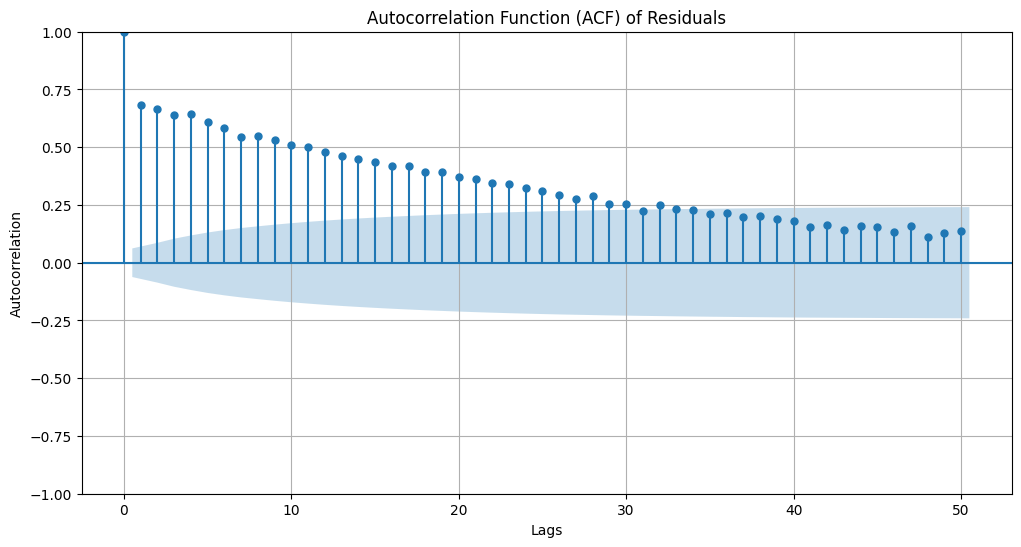

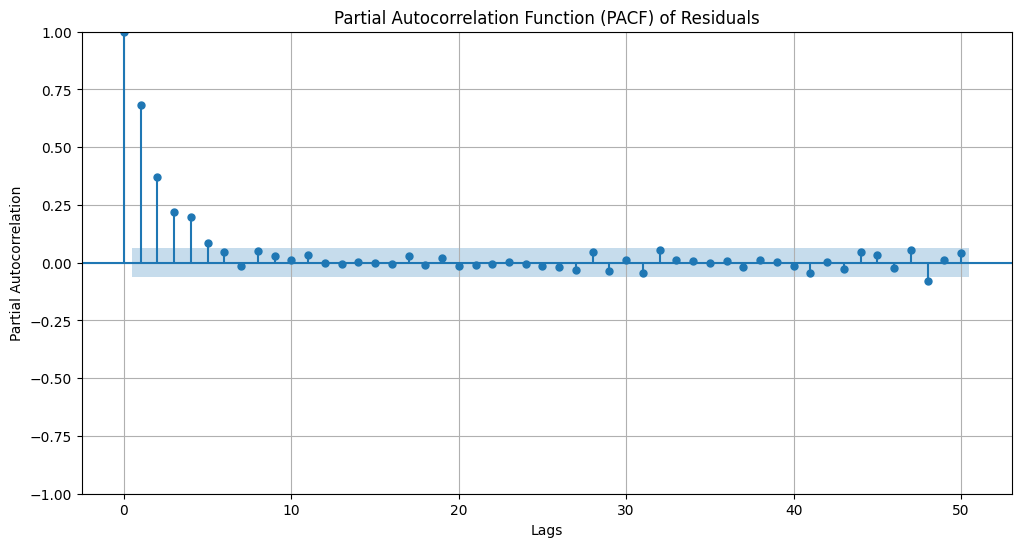

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals_simplified, lags=50, ax=plt.gca()) # You can adjust the number of lags
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot PACF of residuals
plt.figure(figsize=(12, 6))
plot_pacf(residuals_simplified, lags=50, ax=plt.gca()) # You can adjust the number of lags
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

# AR(5)

 Per affrontare l'autocorrelazione nei residui, è stato adattato un modello Autoregressivo di ordine 5 (AR(5)) ai residui del modello OLS semplificato.

In [22]:
# from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(5, 0, 0) model to the residuals
# The order (p, d, q) is (AR order, differencing order, MA order)
# So ARIMA(5, 0, 0) is an AR(5) model
arima_model_residuals = ARIMA(residuals_simplified, order=(5, 0, 0))
arima_results_residuals = arima_model_residuals.fit()

# Print the model summary
print(arima_results_residuals.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -2298.851
Date:                Sun, 19 Oct 2025   AIC                           4611.702
Time:                        17:02:08   BIC                           4646.056
Sample:                             0   HQIC                          4624.759
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0746      0.647     -0.115      0.908      -1.342       1.193
ar.L1          0.2875      0.031      9.339      0.000       0.227       0.348
ar.L2          0.2125      0.032      6.712      0.0

## Residuals of combiened model (OLS + AR(5))

- Sono stati creati un istogramma, un grafico Q-Q dei residui del modello AR(5) per verificare la normalità visivamente.

- Sono stati generati grafici ACF e PACF dei residui del modello AR(5) per verificare se l'autocorrelazione fosse stata rimossa.

- È stato eseguito il test di Ljung-Box sui residui del modello AR(5) per una verifica formale della "white noise" (assenza di autocorrelazione significativa). Il test suggerisce che i residui sono rumore bianco.

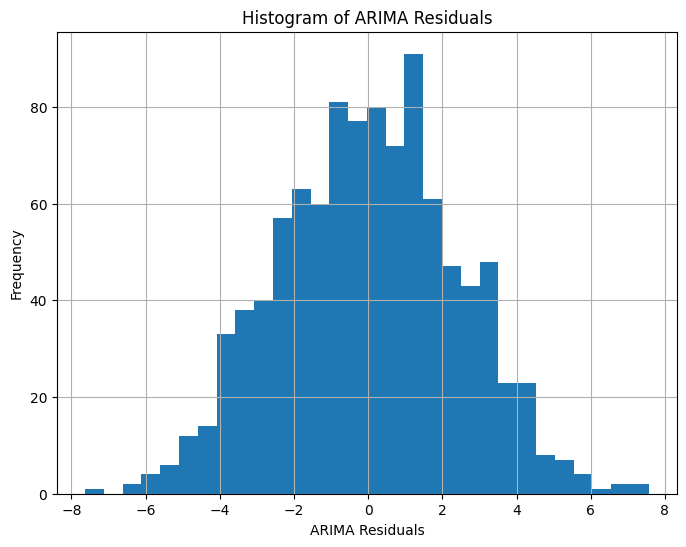

<Figure size 800x600 with 0 Axes>

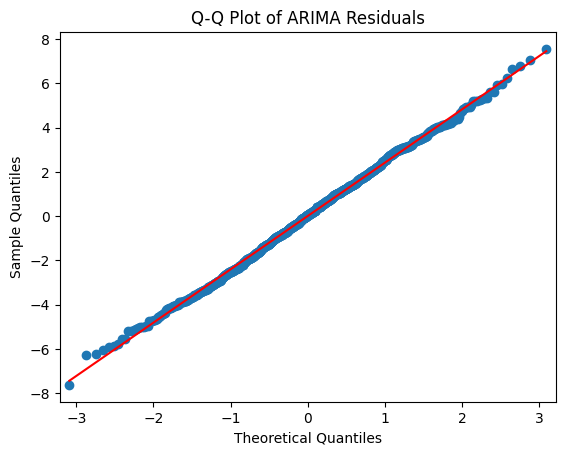

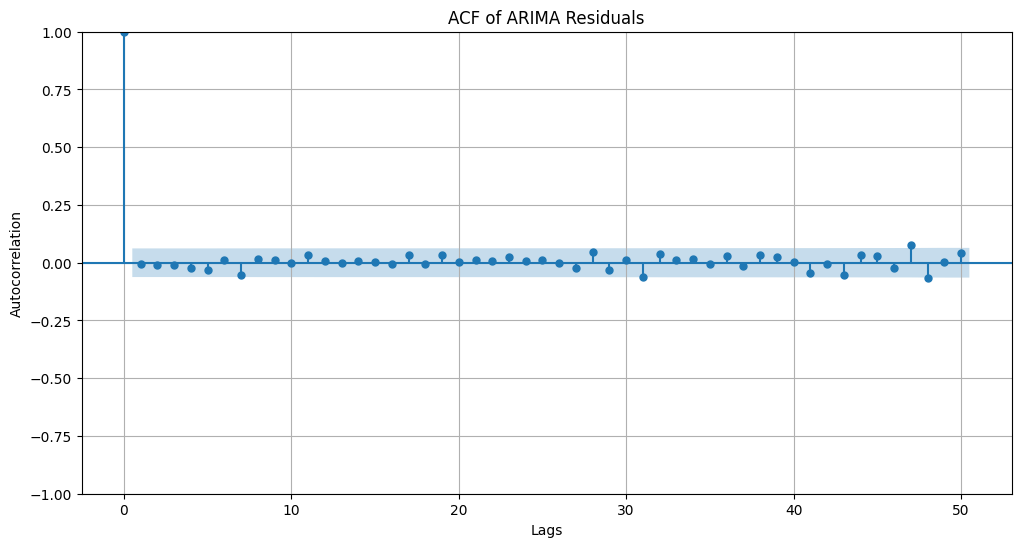

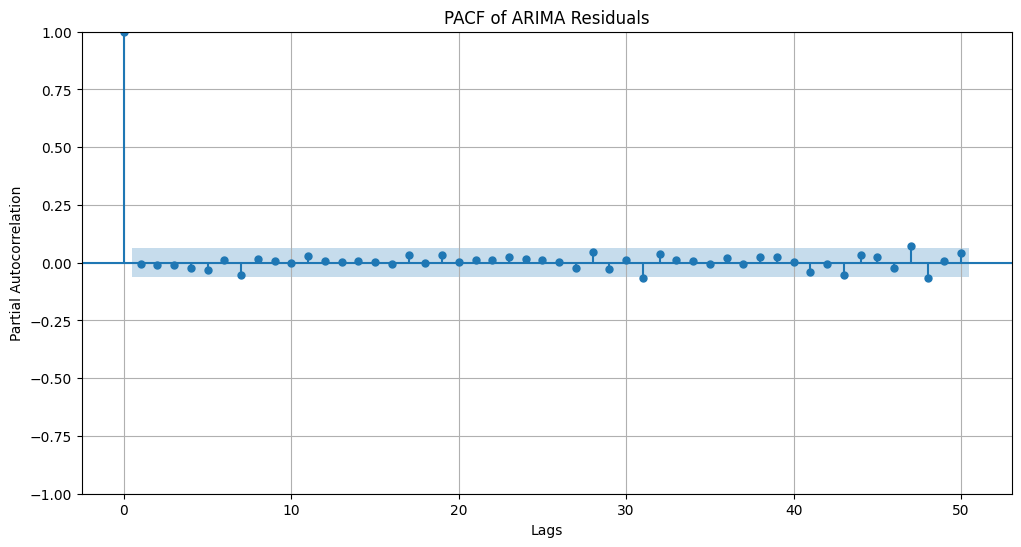


Ljung-Box Test Results for ARIMA Residuals:


,lb_stat,lb_pvalue
10,5.104127,0.884114
20,8.605258,0.987045


In [23]:
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.stats.diagnostic import acorr_ljungbox

# Get the residuals from the ARIMA model
arima_residuals = arima_results_residuals.resid

# 1. Check Normality (Visual)
plt.figure(figsize=(8, 6))
plt.hist(arima_residuals, bins=30)
plt.xlabel('ARIMA Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of ARIMA Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sm.qqplot(arima_residuals, line='s')
plt.title('Q-Q Plot of ARIMA Residuals')
plt.show()

# 2. Check for Autocorrelation (White Noise Check - Visual)
plt.figure(figsize=(12, 6))
plot_acf(arima_residuals, lags=50, ax=plt.gca())
plt.title('ACF of ARIMA Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(arima_residuals, lags=50, ax=plt.gca())
plt.title('PACF of ARIMA Residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

# 3. Formal White Noise Check (Ljung-Box Test)
# The Ljung-Box test checks if a series is white noise up to a certain number of lags
# We'll test up to, say, 10 or 20 lags.
ljungbox_test = acorr_ljungbox(arima_residuals, lags=[10, 20], return_df=True)

print("\nLjung-Box Test Results for ARIMA Residuals:")
display(ljungbox_test)

# Interpretation of Ljung-Box Test:
# If the p-value for a given lag is > alpha (e.g., 0.05), we fail to reject the null hypothesis
# that there is no significant autocorrelation up to that lag (i.e., it's white noise).

# Combined model OLS + AR(5) formula

Il modello generale stimato combina una **regressione lineare OLS** con una **struttura autoregressiva AR(5)** sui residui. La cui formula è la seguente:


\
\begin{aligned}
CO_{2,t} &= 399.67
+ 11.77 \, People_t
- 2.64 \, I(Window_t = 1)
- 10.31 \, I(Door_t = 1) I(Window_t = 1) \\
&\quad + 0.287\,u_{t-1}
+ 0.213\,u_{t-2}
+ 0.128\,u_{t-3}
+ 0.171\,u_{t-4}
+ 0.085\,u_{t-5}
+ \varepsilon_t
\end{aligned}




# Predict

È stato mostrato un esempio di come utilizzare i parametri stimati del modello combinato (OLS + AR(5) sui residui) per fare una previsione del CO2 futura basata su uno scenario di valori per le variabili predittrici e gli ultimi residui osservati.

In [24]:

# --- Parametri stimati del modello ---
beta_0 = 399.67
beta_people = 11.77
beta_window = -2.64
beta_door_window = -10.31

phi = [0.287, 0.213, 0.128, 0.171, 0.085]  # AR(5) residui

# --- Scenario di previsione --- # INSERISCI IL TUO SCENARIO DI PREVISIONE
people_value = 3
window_value = 1
door_value = 1
door_window_interaction_value = door_value * window_value

# --- Ultimi 5 residui osservati (ut-1, ..., ut-5) ---
# Sostituire con i residui reali del tuo modello OLS
last_residuals = np.array([0.5, -0.3, 0.2, -0.1, 0.05])  # esempio

# --- Calcolo componente OLS ---
ols_part = (beta_0 +
            beta_people * people_value +
            beta_window * window_value +
            beta_door_window * door_window_interaction_value)

# --- Calcolo componente AR(5) sui residui ---
ar_part = np.dot(phi, last_residuals)

# --- Previsione finale ---
predicted_co2 = ols_part + ar_part

print(f"Predicted CO2: {predicted_co2:.2f}")


Predicted CO2: 422.12


# Metrics

Sono state calcolate e stampate le metriche R-squared, Mean Squared Error (MSE) e Root Mean Squared Error (RMSE) per il modello OLS semplificato.

In [25]:
# from sklearn.metrics import mean_squared_error


# R-squared is available directly from the model summary
r_squared = model_simplified.rsquared

# Mean Squared Error (MSE)
mse = mean_squared_error(data['co2'], model_simplified.predict(data))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"R-squared: {r_squared:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R-squared: 0.8341
Mean Squared Error (MSE): 13.8893
Root Mean Squared Error (RMSE): 3.7268
